#### This jupyter notebook is for the evaluation of our hierarchical marker gene selection approach, 
#### including UMAP visualization and classification

In [1]:
import scanpy as sc
import scipy.io
import pandas as pd
import numpy   as np
import tensorflow as tf
from sklearn.decomposition import TruncatedSVD
import random
import os
from ismember import ismember
import sys
from collections import Counter  
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import manifold
import umap  

##### Load and preprocess the data (modify your path to the data)

In [2]:
adata = sc.read_mtx('filtered_gene_bc_matrix\\matrix.mtx')
barcode = pd.read_csv('filtered_gene_bc_matrix\\barcodes.tsv', sep='\t',header=None)

In [68]:
barcode = barcode[0]
label = pd.read_csv('filtered_gene_bc_matrix\\clustering_result_from_seurat.tsv', sep='\t',header=None)
barcode_label = label[0]
label = label[1]
label[label=="Mk"]="Platelet"

In [4]:
genes = pd.read_csv('Y:\\qiu-lab\\mapping_to_atlas\\datasets\\PBMC_10x_3K\\filtered_gene_bc_matrix\\genes.tsv',sep='\t', header=None)
genes = genes[1]

In [5]:
adata = sc.AnnData(X=adata)
adata.obs_names = genes
adata.var_names = barcode

In [6]:
barcode = pd.Index(barcode)
barcode_label = pd.Index(barcode_label)
test = barcode.intersection(barcode_label)
adata = adata[:,test]

In [35]:
adata.var_names = label
adata_df = adata.to_df()

In [38]:
adata_df_colsum = np.sum(adata_df)
adata_df_norm = (adata_df/adata_df_colsum)*10000

#### hierarchical structure constructed by our proposed approach implemented with R (pbmc_3k_hierarchy.R)

In [39]:
hierarchical_signature_model=[["Naive CD4 T;Memory CD4 T;CD8 T;B;CD14+ Mono;DC;FCGR3A+ Mono;NK","Platelet"],
                              ["Naive CD4 T;Memory CD4 T;CD8 T;B;NK","CD14+ Mono;DC;FCGR3A+ Mono"],
                              ["Naive CD4 T;Memory CD4 T;CD8 T;B","NK"],
                              ["CD14+ Mono;FCGR3A+ Mono","DC"],
                              ["Naive CD4 T;Memory CD4 T;CD8 T","B"],
                              ["CD14+ Mono","FCGR3A+ Mono"],
                              ["Naive CD4 T;Memory CD4 T","CD8 T"],
                              ["Naive CD4 T","Memory CD4 T"]] 

#### Marker genes corresponding to each hierarchical level selected by Seurat FindAllMarkers function

In [40]:
hierarchical_signature_genes=[[["MALAT1","RPL14","RPS24","RPL9","RPL7","RPS27A","RPSA","RPS4Y1","BTG1","IL32"],
                         ["GP9","SPARC","PF4","GNG11","SDPR","CLU","PPBP","TUBB1","CD9","HIST1H2AC"]],
                             [["PTPRCAP","LTB","IL32","CD3D","CD3E","CD7","CTSW","CST7","CCL5","NKG7"],
                         ["S100A9","S100A8","LYZ","CST3","LST1","TYROBP","FCN1","AIF1","LGALS2","FTL"]],
                              [["RPS12","LTB","RPL36A","CD3D","VIM","IL7R","CD27","HLA-DRB1","HLA-DPB1","HLA-DRA"],["GZMB","FGFBP2","SPON2","FCGR3A","PRF1","GNLY","FCER1G","TYROBP","CCL4","NKG7"]],
                              [["FTL","CFD","S100A9","S100A8","FCN1","SERPINA1","CDA","APOBEC3A","CD14","FCGR3A"],["FCER1A","CD1C","CLEC10A","HLA-DQA2","HLA-DQA1","HLA-DQB1","CD74","HLA-DPB1","HLA-DRA","HLA-DRB1"]],
                              [["CD3D","IL32","CD3E","GIMAP7","S100A4","IL7R","ANXA1","CD2","CCL5","NKG7"],["CD79A","HLA-DQA1","CD79B","HLA-DQB1","HLA-DRB1","HLA-DRA","HLA-DPA1","HLA-DPB1","TCL1A","CD74"]],
                              [["LYZ","S100A8","S100A9","LGALS2","GPX1","CD14","MS4A6A","FOLR3","S100A12","CCL3"],["FCGR3A","RHOC","IFITM2","CDKN1C","ADA","HES4","MS4A7","CD79B","RP11-290F20.3","ABI3"]],
                              [["LDHB","LTB","JUNB","CCR7","LEF1","MAL","NOSIP","FYB","PLP2","SLC2A3"],["NKG7","CST7","GZMA","CCL5","GZMH","GZMK","CCL4","FGFBP2","GZMB","GNLY"]],
                              [["MALAT1","RPL21","RPS3A","CCR7","SELL","C6orf48","AIF1","RSL1D1","PRKCQ-AS1","LEF1"],["S100A4","ANXA1","S100A11","ANXA2","CLIC1","LGALS1","S100A10","DOK2","CORO1B","ISG15"]]]
                              
                              

In [41]:
matlab_all_list = ["Naive CD4 T","CD14+ Mono","Memory CD4 T","B","CD8 T","FCGR3A+ Mono","NK","DC","Platelet"]

#### Generate the data matrix behind compact hierarchical heatmap
##### first generate a mask that cover up the cell subset not included in a specific lineage

In [73]:
adata_df_norm_ = np.log2(1+(adata_df/adata_df_colsum)*100000)
adata_df_norm_ = (adata_df_norm_-adata_df_norm_.mean(axis=0))/adata_df_norm_.std(axis=0)
adata_df_norm_mask = adata_df_norm_.copy()
genes_vis=[]
for i in range(len(hierarchical_signature_genes)):
    cell_type = []
    for j in range(len(hierarchical_signature_model[i])):
        cell_type+=(hierarchical_signature_model[i][j].split(';'))
    print("cell types in the lineage: ",cell_type) ####what cell types included in this level   
    level_genes = []
    for p in range(len(hierarchical_signature_genes[i])):###what sig genes included in this level
        level_genes+=hierarchical_signature_genes[i][p]#[:20]
    print("corresponding marker genes: ",level_genes)
    genes_vis+=level_genes    
    adata_df_norm_mask.loc[adata_df_norm.index.isin(level_genes),list(set(matlab_all_list)-set(cell_type))]=np.nan
    

0
['Naive CD4 T', 'Memory CD4 T', 'CD8 T', 'B', 'CD14+ Mono', 'DC', 'FCGR3A+ Mono', 'NK', 'Platelet']
['MALAT1', 'RPL14', 'RPS24', 'RPL9', 'RPL7', 'RPS27A', 'RPSA', 'RPS4Y1', 'BTG1', 'IL32', 'GP9', 'SPARC', 'PF4', 'GNG11', 'SDPR', 'CLU', 'PPBP', 'TUBB1', 'CD9', 'HIST1H2AC']
(32738, 2638)
1
['Naive CD4 T', 'Memory CD4 T', 'CD8 T', 'B', 'NK', 'CD14+ Mono', 'DC', 'FCGR3A+ Mono']
['PTPRCAP', 'LTB', 'IL32', 'CD3D', 'CD3E', 'CD7', 'CTSW', 'CST7', 'CCL5', 'NKG7', 'S100A9', 'S100A8', 'LYZ', 'CST3', 'LST1', 'TYROBP', 'FCN1', 'AIF1', 'LGALS2', 'FTL']
(32738, 2638)
2
['Naive CD4 T', 'Memory CD4 T', 'CD8 T', 'B', 'NK']
['RPS12', 'LTB', 'RPL36A', 'CD3D', 'VIM', 'IL7R', 'CD27', 'HLA-DRB1', 'HLA-DPB1', 'HLA-DRA', 'GZMB', 'FGFBP2', 'SPON2', 'FCGR3A', 'PRF1', 'GNLY', 'FCER1G', 'TYROBP', 'CCL4', 'NKG7']
(32738, 2638)
3
['CD14+ Mono', 'FCGR3A+ Mono', 'DC']
['FTL', 'CFD', 'S100A9', 'S100A8', 'FCN1', 'SERPINA1', 'CDA', 'APOBEC3A', 'CD14', 'FCGR3A', 'FCER1A', 'CD1C', 'CLEC10A', 'HLA-DQA2', 'HLA-DQA1', 'HLA-

#### re-order the cells based on cell types

In [111]:
cat_order = ["Naive CD4 T","Memory CD4 T","CD8 T","B","NK","CD14+ Mono","FCGR3A+ Mono","DC","Platelet"]
df0 = adata_df_norm_mask[cat_order[0]]
df1 = adata_df_norm_mask[cat_order[1]]
df2 = adata_df_norm_mask[cat_order[2]]
df3 = adata_df_norm_mask[cat_order[3]]
df4 = adata_df_norm_mask[cat_order[4]]
df5 = adata_df_norm_mask[cat_order[5]]
df6 = adata_df_norm_mask[cat_order[6]]
df7 = adata_df_norm_mask[cat_order[7]]
df8 = adata_df_norm_mask[cat_order[8]]

#### generate the data matrix

In [112]:
frames = [df0, df1, df2,df3,df4,df5,df6,df7,df8]


result = pd.concat(frames,axis=1)

hierachical_heatmap = pd.DataFrame(index=genes_vis,columns=list(result.columns))
count = 0
for i in range(len(hierarchical_signature_model)):
    cell_type = []
    for j in range(len(hierarchical_signature_model[i])):
        cell_type+=(hierarchical_signature_model[i][j].split(';'))    
    level_genes = []
    for p in range(len(hierarchical_signature_genes[i])):
        level_genes+=hierarchical_signature_genes[i][p]#[:10]  
    for q in range(len(level_genes)):
        hierachical_heatmap.iloc[count+q][list(set(cell_type))]=result.loc[result.index.isin([level_genes[q]]),list(set(cell_type))].squeeze()
    count = count+len(level_genes)
hie_mask = hierachical_heatmap.isna()
hierachical_heatmap = hierachical_heatmap.fillna(0)

0
0
['Naive CD4 T', 'Memory CD4 T', 'CD8 T', 'B', 'CD14+ Mono', 'DC', 'FCGR3A+ Mono', 'NK', 'Platelet']
['MALAT1', 'RPL14', 'RPS24', 'RPL9', 'RPL7', 'RPS27A', 'RPSA', 'RPS4Y1', 'BTG1', 'IL32', 'GP9', 'SPARC', 'PF4', 'GNG11', 'SDPR', 'CLU', 'PPBP', 'TUBB1', 'CD9', 'HIST1H2AC']
1
20
['Naive CD4 T', 'Memory CD4 T', 'CD8 T', 'B', 'NK', 'CD14+ Mono', 'DC', 'FCGR3A+ Mono']
['PTPRCAP', 'LTB', 'IL32', 'CD3D', 'CD3E', 'CD7', 'CTSW', 'CST7', 'CCL5', 'NKG7', 'S100A9', 'S100A8', 'LYZ', 'CST3', 'LST1', 'TYROBP', 'FCN1', 'AIF1', 'LGALS2', 'FTL']
2
40
['Naive CD4 T', 'Memory CD4 T', 'CD8 T', 'B', 'NK']
['RPS12', 'LTB', 'RPL36A', 'CD3D', 'VIM', 'IL7R', 'CD27', 'HLA-DRB1', 'HLA-DPB1', 'HLA-DRA', 'GZMB', 'FGFBP2', 'SPON2', 'FCGR3A', 'PRF1', 'GNLY', 'FCER1G', 'TYROBP', 'CCL4', 'NKG7']
3
60
['CD14+ Mono', 'FCGR3A+ Mono', 'DC']
['FTL', 'CFD', 'S100A9', 'S100A8', 'FCN1', 'SERPINA1', 'CDA', 'APOBEC3A', 'CD14', 'FCGR3A', 'FCER1A', 'CD1C', 'CLEC10A', 'HLA-DQA2', 'HLA-DQA1', 'HLA-DQB1', 'CD74', 'HLA-DPB1', 'HLA

#### classification
#### initialize a knn classifier

In [96]:
clf=KNeighborsClassifier() 

#### split the data:  70% of training and 30% for testing

In [97]:
y_test = hierachical_heatmap.columns
X_train, X_test, y_train, y_test = train_test_split(hierachical_heatmap.T,y_test,test_size = 0.3, random_state = 42)

#### Train and test the classifier

In [98]:
clf.fit(X_train, y_train)

KNeighborsClassifier()

In [100]:
clf.score(X_test,y_test)

0.8926767676767676

#### Check the classification accuracy for each cell type


In [110]:
i='Platelet'
tmp = np.array(X_test)[y_test==i]
clf_pred = clf.predict(tmp)
np.sum(clf_pred==i)/np.array(X_test)[y_test==i].shape[0]

1.0

#### UMAP visualization

In [91]:
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

In [92]:
y_test = np.array(label_encoder.fit_transform(hierachical_heatmap.columns),dtype='uint8')

(2638, 2)


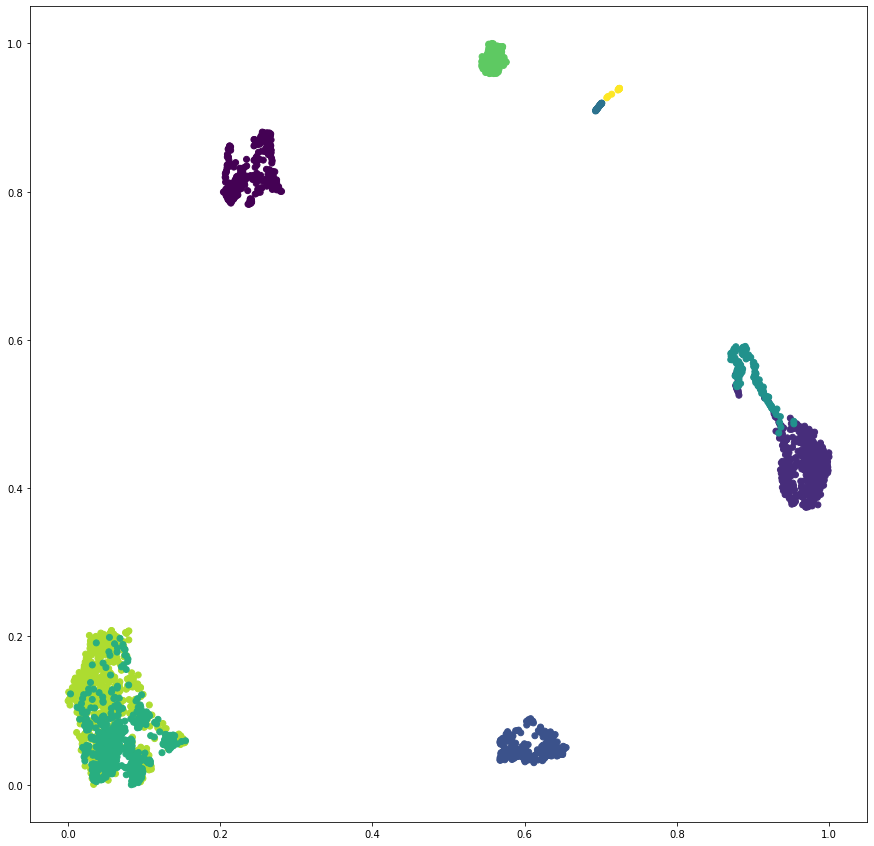

In [93]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(hierachical_heatmap.T)
print(embedding.shape)
x_min, x_max = embedding.min(0), embedding.max(0)
X_norm = (embedding - x_min) / (x_max - x_min)  # 归一化
plt.figure(figsize=(15, 15))
plt.scatter(X_norm[:, 0], X_norm[:, 1], c=y_test)

plt.show()